In [1]:
import tensorflow as tf
from keras import models, layers
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/UTKFace_regression.zip'


Streaming output truncated to the last 5000 lines.
  inflating: UTKFace_regression/49_1_0_20170109141328213.jpg.chip.jpg  
  inflating: UTKFace_regression/49_1_0_20170109142119876.jpg.chip.jpg  
  inflating: UTKFace_regression/49_1_0_20170109142131660.jpg.chip.jpg  
  inflating: UTKFace_regression/49_1_0_20170109220421978.jpg.chip.jpg  
  inflating: UTKFace_regression/49_1_0_20170109220426712.jpg.chip.jpg  
  inflating: UTKFace_regression/49_1_0_20170109220434368.jpg.chip.jpg  
  inflating: UTKFace_regression/49_1_0_20170109220611995.jpg.chip.jpg  
  inflating: UTKFace_regression/49_1_0_20170109220635624.jpg.chip.jpg  
  inflating: UTKFace_regression/49_1_0_20170109220855652.jpg.chip.jpg  
  inflating: UTKFace_regression/49_1_0_20170109221050190.jpg.chip.jpg  
  inflating: UTKFace_regression/49_1_0_20170109221102358.jpg.chip.jpg  
  inflating: UTKFace_regression/49_1_0_20170109221146542.jpg.chip.jpg  
  inflating: UTKFace_regression/49_1_0_20170110125307207.jpg.chip.jpg  
  inflating: 

In [3]:
BASE_DIR = '/content/UTKFace_regression/'
age_labels = []

image_paths = []


In [4]:
image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

In [5]:
for image in tqdm(image_filenames):
   image_path = os.path.join(BASE_DIR, image)
   img_components = image.split('_')
   age_label = int(img_components[0])
   age_labels.append(age_label)
   image_paths.append(image_path)

  0%|          | 0/19474 [00:00<?, ?it/s]

In [6]:
print(f'Number of age_labels: {len(age_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 19474, Number of image_paths: 19474


Exploratory Data Anlysis


In [7]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'] = image_paths, age_labels
df.head(5)

,image_path,age
0,/content/UTKFace_regression/75_1_0_20170110183...,75
1,/content/UTKFace_regression/25_1_0_20170117195...,25
2,/content/UTKFace_regression/26_1_1_20170116153...,26
3,/content/UTKFace_regression/18_1_3_20170104221...,18
4,/content/UTKFace_regression/65_1_0_20170110140...,65


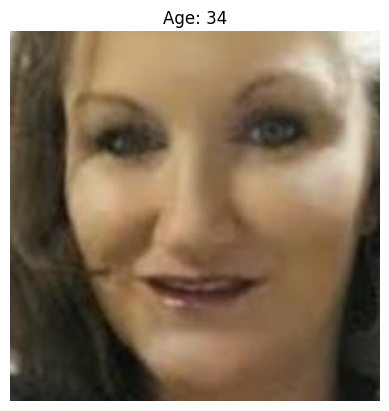

In [8]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age}')
plt.axis('off')
plt.imshow(IMG)

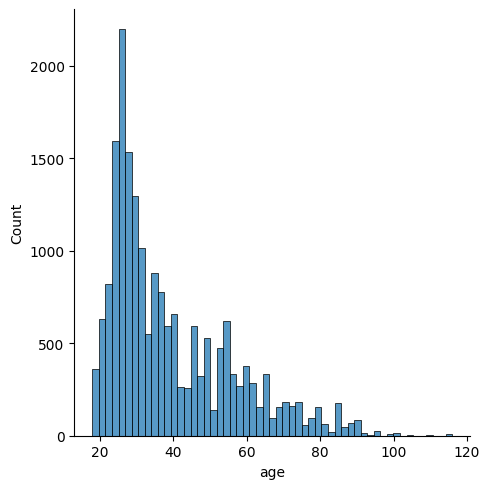

In [9]:
sns.displot(df['age'])

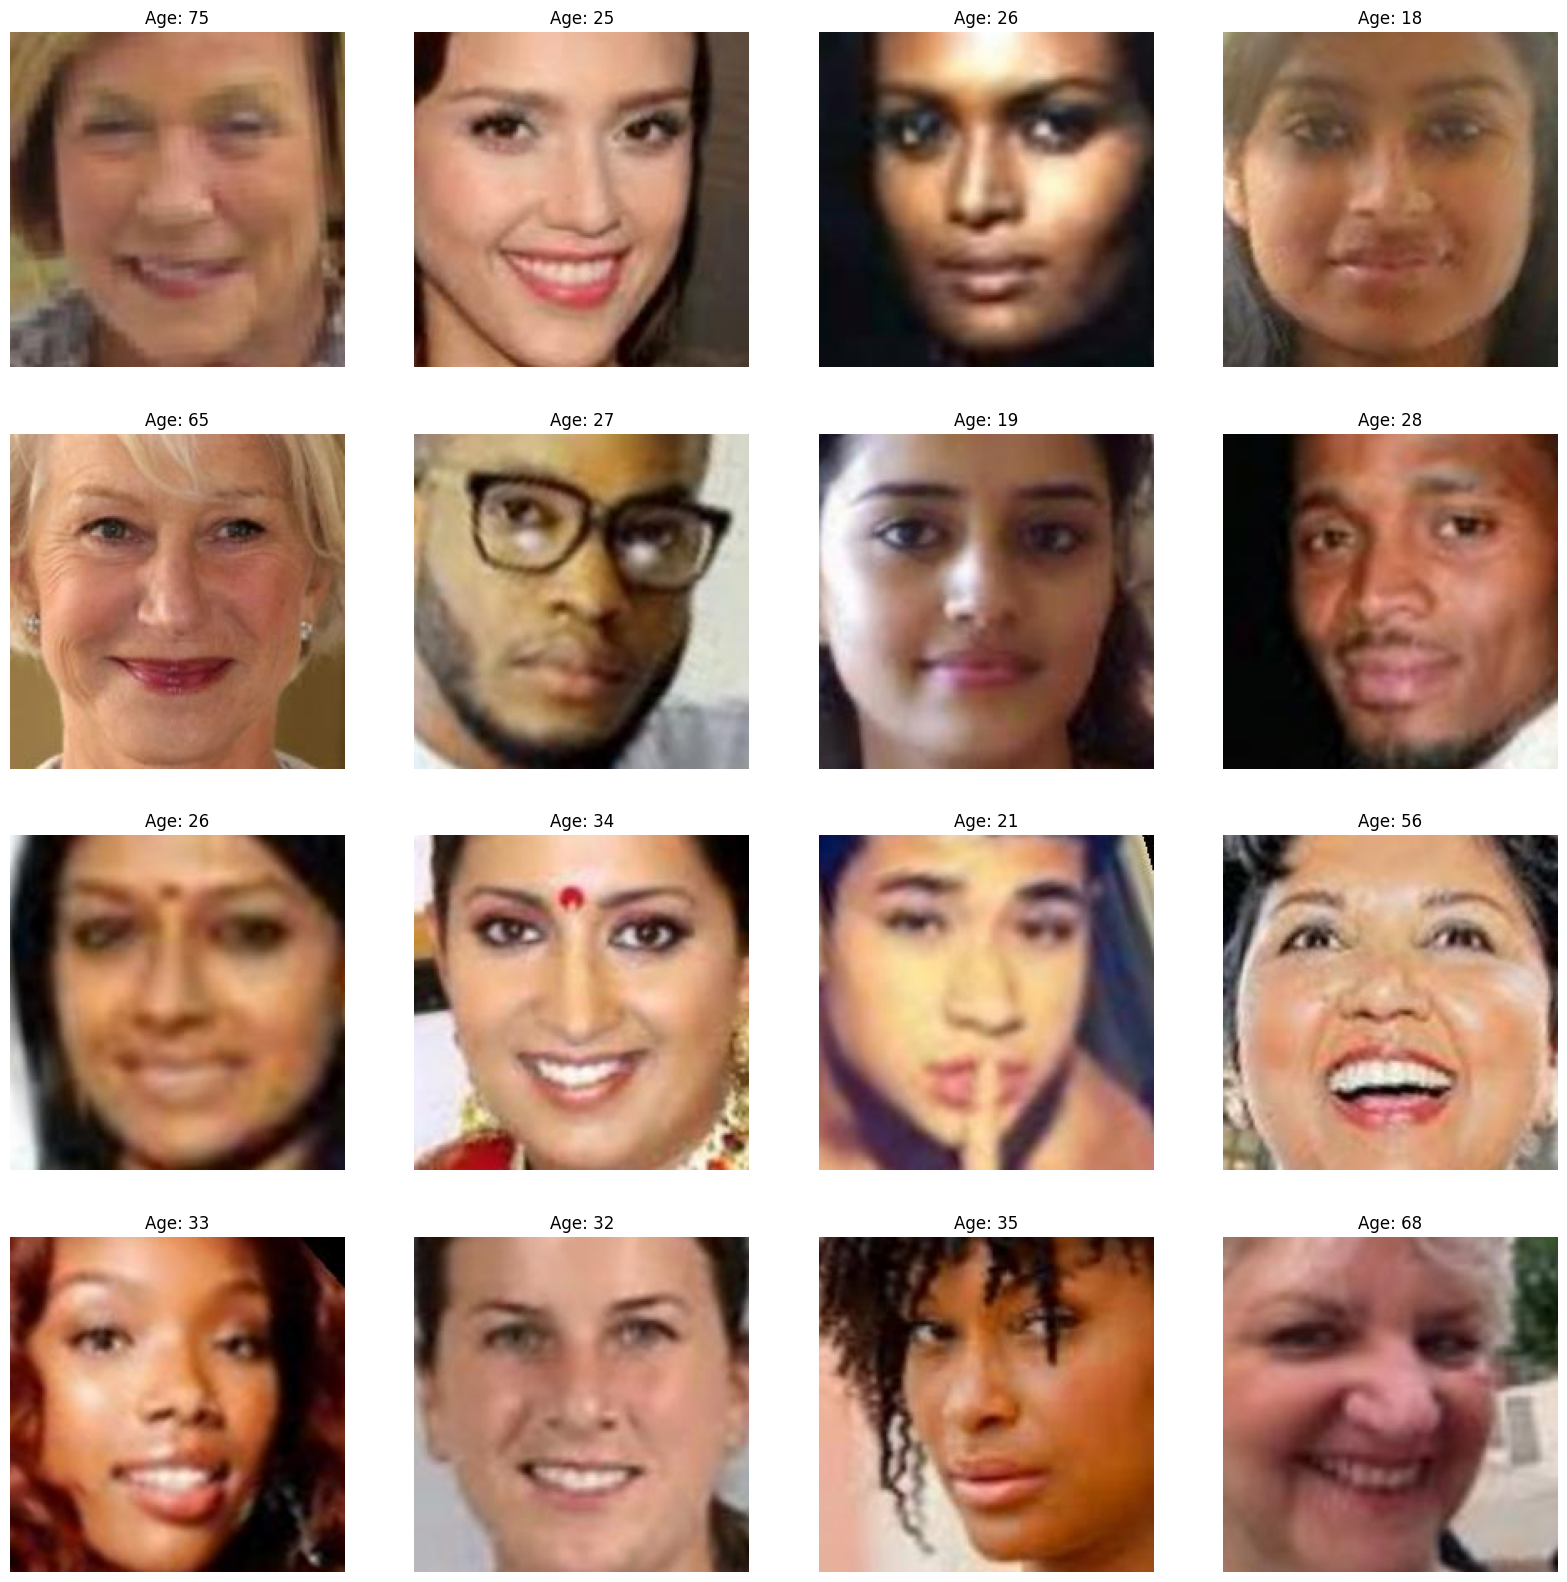

In [10]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age}')
    plt.imshow(img)

In [11]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [12]:
X = extract_image_features(df['image_path'])


  0%|          | 0/19474 [00:00<?, ?it/s]

In [13]:
X.shape


(19474, 128, 128, 1)

In [14]:
X = X / 255.0

In [15]:
y_age = np.array(df['age'])

In [16]:
model = Sequential([
    layers.Input(shape=(128, 128, 1)),
    layers.Flatten(),  # Flatten the 128x128 image into a vector
    layers.Dense(1024, activation='relu'),  # Larger dense layer for feature extraction
    layers.Dropout(0.5),  # Dropout to reduce overfitting
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='linear')  # Linear activation for regression output
])

In [17]:
model.compile(loss='mae',
              optimizer='adam', metrics=['mae'])

In [18]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and temporary (20%) set
X_train, X_temp, y_train_age, y_temp_age = train_test_split(
    X, y_age, test_size=0.2, random_state=42
)

# Now split the temporary set into validation (50%) and test (50%) from the remaining data
X_val, X_test, y_val_age, y_test_age = train_test_split(
    X_temp, y_temp_age, test_size=0.5, random_state=42
)

# Print shapes to verify the split
print("Training set:", X_train.shape, y_train_age.shape)
print("Validation set:", X_val.shape, y_val_age.shape)
print("Testing set:", X_test.shape, y_test_age.shape)

Training set: (15579, 128, 128, 1) (15579,)
Validation set: (1947, 128, 128, 1) (1947,)
Testing set: (1948, 128, 128, 1) (1948,)


In [19]:
history = model.fit(X_train, y_train_age,
                    batch_size=16, epochs=20, validation_data=(X_val, y_val_age))

Epoch 1/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 14.9469 - mae: 14.9469 - val_loss: 14.7395 - val_mae: 14.7395
Epoch 2/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 12.8790 - mae: 12.8790 - val_loss: 13.2063 - val_mae: 13.2063
Epoch 3/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 12.3920 - mae: 12.3920 - val_loss: 17.5591 - val_mae: 17.5591
Epoch 4/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 12.3426 - mae: 12.3426 - val_loss: 18.1264 - val_mae: 18.1264
Epoch 5/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 11.8110 - mae: 11.8110 - val_loss: 16.3354 - val_mae: 16.3354
Epoch 6/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 11.6234 - mae: 11.6234 - val_loss: 16.4024 - val_mae: 16.4024
Epoch 7/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 11.3433 - mae: 11.3433 - val_loss: 17.3032 - val_mae: 17.3032
Epoch 8/20
974/974 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 12.0046 - mae: 12.0046 - val_loss: 12.6892 - val_mae: 12.6892
Epoch 9/20
974/974 ━━

In [20]:
test_results = model.evaluate(X_test, y_test_age)
print(f"Test MAE: {test_results[1]:.2f}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10.8132 - mae: 10.8132
Test MAE: 10.45


In [21]:
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Print the final training and validation MAE
print(f"Final Training MAE: {train_mae[-1]:.2f}")
print(f"Final Validation MAE: {val_mae[-1]:.2f}")

Final Training MAE: 11.44
Final Validation MAE: 10.56


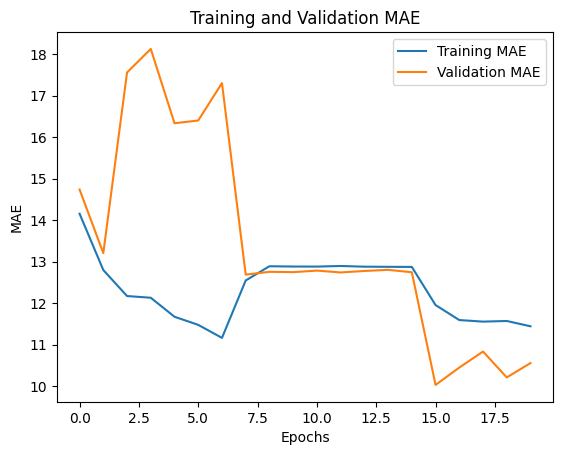

In [22]:
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


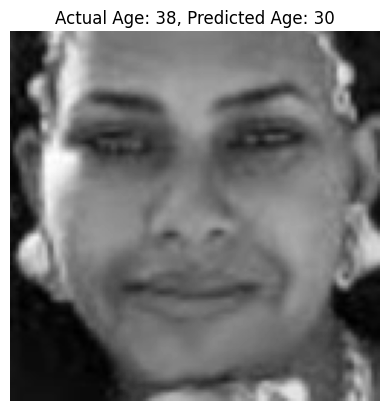

In [25]:
import random

# Randomly select an image from the test dataset
sample_index = random.randint(0, len(X_test) - 1)  # Random index from the test set
sample_image = X_test[sample_index].reshape(1, 128, 128, 1)  # Reshape for model input
predicted_age_single = int(round(model.predict(sample_image)[0][0]))  # Round and cast to integer
actual_age_single = y_test_age[sample_index]

# Display the randomly selected image with the actual and predicted age
plt.imshow(sample_image.reshape(128, 128), cmap='gray')
plt.title(f"Actual Age: {actual_age_single}, Predicted Age: {predicted_age_single}")
plt.axis('off')
plt.show()